In [1]:
import argparse
import os
import glob
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import functional as F

from torchvision import datasets, transforms, utils

from tqdm import tqdm

from vqvae import VQVAE
from scheduler import CycleScheduler

# Data

In [2]:
class vid_faces(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, transform=None):

        self.filenames = glob.glob('/home/jarrod/dev/vq-vae-2-pytorch/vid_test_data/*vid*.npy')
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
          
        img = torch.Tensor(np.load(self.filenames[idx]))
        aud = torch.Tensor(np.load(self.filenames[idx].split('_vid_')[0] + '_aud_' + self.filenames[idx].split('_vid_')[1]))
        
        img = img.permute(2,0,1)
        
        sample = {'image': img, 'audio': aud}

        return sample

In [3]:
# grab the names of the pre-processed video files
video_filenames_proc = glob.glob('/home/jarrod/dev/speech-driven-animation/data/aligned_faces/*.npy')

# grab the names of the pre-processed video files
video_filenames_proc = glob.glob('/home/jarrod/dev/speech-driven-animation/data/aligned_faces/*.npy')

# # delete bad entries
# bad_files = ['bgit2n', 'lbij7a', 'lrbr3s', 'pbio7a', 'sbaa4p', 'sgwp8p', 'sbim8p', 
#              'srwi5a', 'swao7a', 'srbb4n', 'sbbbzp', 'lrae3s']

# for i,f in enumerate(video_filenames_proc):
    
#     for bad in bad_files:
#         if f.find(bad) != -1:
#             del video_filenames_proc[i]
#             break

In [4]:
class getDataSample():
    def __init__(self, gpu=1):

        self.audio_path = '/home/jarrod/dev/speech-driven-animation/data/npy_audio/'
        self.device = torch.device("cuda:" + str(gpu))

        self.mean_face = np.load('/home/jarrod/dev/speech-driven-animation/data/mean_face.npy')
        self.img_size = (128,128)
        self.aux_latent = 10
        self.sequential_noise = True
    
        rnn_gen_dim = 256
        id_enc_dim = 128
        aud_enc_dim = 256
        audio_feat_len = 0.2
        self.audio_rate = 50000
        self.video_rate = 25
        self.audio_feat_samples = 10000
        self.conversion_dict = {'s16': np.int16, 's32': np.int32}
        
        # image preprocessing
        self.img_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((self.img_size[0], self.img_size[1])),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


    def preprocess_img(self, img):
        src = self.fa.get_landmarks(img)[0][self.stablePntsIDs, :]
        dst = self.mean_face[self.stablePntsIDs, :]
        tform = tf.estimate_transform('similarity', src, dst)  # find the transformation matrix
        warped = tf.warp(img, inverse_map=tform.inverse, output_shape=self.img_size)  # wrap the frame image
        warped = warped * 255  # note output from wrap is double image (value range [0,1])
        warped = warped.astype('uint8')

        return warped

    def __call__(self, filename, num_d1_samples, fs=None, aligned=False):
        
        audio_filename = self.audio_path + filename.split('/')[-1].split('.npy')[0] + '.wav.npy'
        
       
    
        vid_data = np.load(filename)
        frame = np.copy(vid_data[0])
                
        # take the input image and preprocess it    
        frame = self.img_transform(frame)
            
        frame = frame.unsqueeze(0)
        
        # Load preprocessed audio data
        audio_feat_seq = np.load(audio_filename)
        
        audio_feat_seq = torch.Tensor(audio_feat_seq)
        audio_feat_seq_length = audio_feat_seq.shape[1]
                
        samp = np.random.rand(num_d1_samples)*audio_feat_seq_length
        samp = samp.astype(int)

        
        normed_vid_data = []
        
        for i, img in enumerate(vid_data):
            normed_vid_data.append((self.img_transform(img)+ 1.0) / 2.0)
        
        normed_vid_data = torch.stack(normed_vid_data)
        
#         d1_frames = normed_vid_data[samp]

        # shuffle the id frames, otherwise the discriminator learns too fast    
#         np.random.shuffle(samp)
#         d1_frames_shuff = normed_vid_data[samp]

#         frame_c = frame.repeat(num_d1_samples,1,1,1) 
        # concat the id_frame onto the back of axis 1 (indices 3:)
#         d1_frames = torch.cat((d1_frames, d1_frames_shuff), axis=1)
        
        
        return audio_feat_seq, audio_feat_seq_length, frame, normed_vid_data

In [5]:
va = getDataSample()

# Train

In [6]:
device = 'cuda'

latent_loss_weight = 0.25

LR = 1e-3

mse_sum = 0
mse_n = 0

model = nn.DataParallel(VQVAE()).to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()
scheduler = None

/home/jarrod/.pyenv/versions/3.7.1/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:26: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE:  0.019906867295503616 latent loss:  0.005092889070510864 avg MSE:  0.04669609671349034


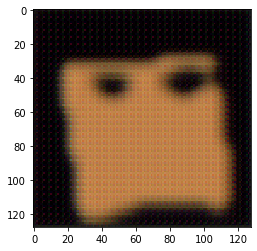

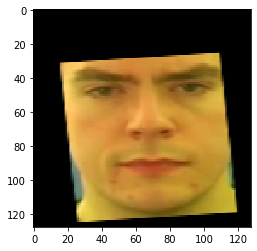

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE:  0.01828000880777836 latent loss:  0.009521620348095894 avg MSE:  0.030358051125070836


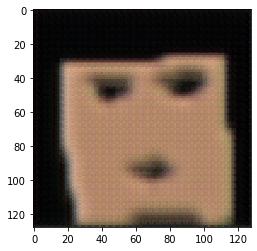

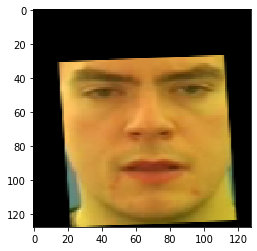

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE:  0.011214814148843288 latent loss:  0.02298499271273613 avg MSE:  0.02477624232368803


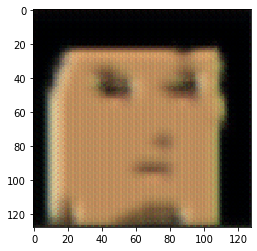

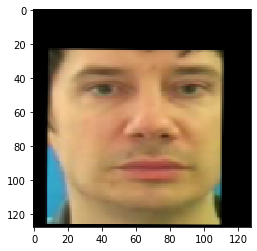

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE:  0.01438257284462452 latent loss:  0.02384467050433159 avg MSE:  0.02149377900658429


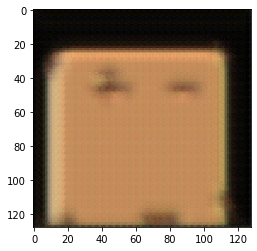

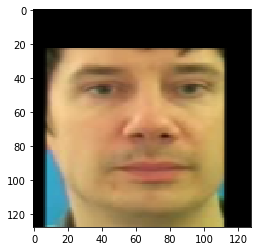

In [ ]:
for i, filename in enumerate(video_filenames_proc):
    
    model.zero_grad()

    aud, _, _, vid  = va(filename, 10, aligned=True)
    
    
    img = vid.to(device)

    out, latent_loss = model(img)
    recon_loss = criterion(out, img)
    latent_loss = latent_loss.mean()
    
    loss = recon_loss + latent_loss_weight * latent_loss
    loss.backward()

    if scheduler is not None:
        scheduler.step()
    
    optimizer.step()

    mse_sum += recon_loss.item() * img.shape[0]
    mse_n += img.shape[0]

    lr = optimizer.param_groups[0]['lr']

    if i % 50 == 0 and i != 0:
        print("MSE: ", recon_loss.item(), "latent loss: ", latent_loss.item(), "avg MSE: ", mse_sum / mse_n)
        test_img = np.moveaxis(out.cpu().detach().numpy(),1,-1)
        inp_img = np.moveaxis(img.cpu().detach().numpy(),1,-1)
        plt.imshow(test_img[0])
        plt.show()
        plt.imshow(inp_img[0])
        plt.show()
        
    
#     loader.set_description(
#         (
#             f'epoch: {epoch + 1}; mse: {recon_loss.item():.5f}; '
#             f'latent: {latent_loss.item():.3f}; avg mse: {mse_sum / mse_n:.5f}; '
#             f'lr: {lr:.5f}'
#         )
#     )

#     if i % 100 == 0:
#         model.eval()

#         sample = img[:sample_size]

#         with torch.no_grad():
#             out, _ = model(sample)

#         utils.save_image(
#             torch.cat([sample, out], 0),
#             f'sample/{str(epoch + 1).zfill(5)}_{str(i).zfill(5)}.png',
#             nrow=sample_size,
#             normalize=True,
#             range=(-1, 1),
#         )

#         model.train()

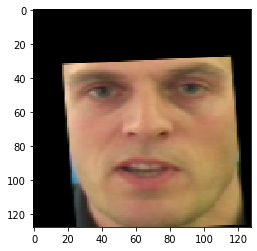

In [13]:
inp_img = np.moveaxis(img.cpu().detach().numpy(),1,-1)
plt.imshow(inp_img[60])
plt.show()